In [7]:
import numpy as np

import time
import sys

from matplotlib import pyplot as plt

### Moment expansion ###

Example of how to use the code to compute the redshift-space power spectrum using the moment expansion (and ancillary quantities, like the velocity moments).

The first step is to import the MomentExpansion class and initialize it.  The first time this is run it can be a bit slow, but once this has been run the first time on a given platform you can save the 'wisdom' file that FFTW uses and this will speed up further executions (using the `export_wisdom` method of MomentExpansion).

Let's start with the LPT code:

In [8]:
from LPT.moment_expansion_fftw import MomentExpansion

In [9]:
# To match the plots in Chen, Vlah & White (2020) let's
# work at z=0.8, and scale our initial power spectrum
# to that redshift:
z,D,f      = 0.8,0.6819,0.8076
klin,plin  = np.loadtxt("pk.dat",unpack=True)
plin      *= D**2

In [18]:
# Initialize the class -- with no wisdom file passed it will
# experiment to find the fastest FFT algorithm for the system.
start= time.time()
mome = MomentExpansion(klin,plin)
print("Elapsed time: ",time.time()-start," seconds.")
# You could save the wisdom file here if you wanted:
# mome.export_wisdom(wisdom_file_name)

Elapsed time:  8.767044067382812  seconds.


We'll start with how to compute $P(k,\mu)$ given a linear theory $P(k)$ file:

In [19]:
# Set up some fiducial values for the parameters -- we'll use the
# examples from the paper and we'll used the "reduced" parameter set:
# pars: the biases and counter terms.
#    b1,b2,bs, b3: linear, quadratic & cubic parameters
#    alpha0,alpha2,alpha4: counterterms
#    sn,s0: stochastic contributions to P(k) and sigma^2.
biases = [0.70,0.5,-0.3,0.0]
cterms = [10.0,20.,-60.]
stoch  = [1800.,-1000.]
pars   = biases + cterms + stoch
#
# Compute the wedges, here we'll just to a single mu.  Note if we
# just wanted the real-space power spectrum we could pass mu=0 to
# compute_redshift_space_power_at_mu.  Here we'll do mu=0.5:
mu     = 0.5
start  = time.time()
kw,pkw = mome.compute_redshift_space_power_at_mu(pars,f,mu,reduced=True)
print("Elapsed time: ",time.time()-start," seconds.")

Elapsed time:  0.00102996826171875  seconds.


In [20]:
print("# First few k bins for mu=",mu)
print("# {:>10s} {:>12s}".format("k","P(k,mu)"))
for k,p in zip(kw[:10],pkw[:10]):
    print("{:12.4e} {:12.4e}".format(k,p))

# First few k bins for mu= 0.5
#          k      P(k,mu)
  1.0000e-03   1.0426e+04
  1.0842e-03   1.1093e+04
  1.1756e-03   1.1806e+04
  1.2746e-03   1.2569e+04
  1.3819e-03   1.3385e+04
  1.4983e-03   1.4255e+04
  1.6246e-03   1.5182e+04
  1.7614e-03   1.6169e+04
  1.9098e-03   1.7216e+04
  2.0706e-03   1.8327e+04


And now let's look at the (even) multipoles, $P_{\ell}(k)$:

In [21]:
# It's about as easy to compute the multipole moments up to ell=4:
start       = time.time()
kl,p0,p2,p4 = mome.compute_redshift_space_power_multipoles(pars,f,reduced=True)
print("Elapsed time: ",time.time()-start," seconds.")

Elapsed time:  0.0029273033142089844  seconds.


In [22]:
print("# First few k bins for multipoles")
print("# {:>10s} {:>12s} {:>12s} {:>12s}".format("k","P0","P2","P4"))
for k,mono,quad,hexa in zip(kl[:10],p0[:10],p2[:10],p4[:10]):
    print("{:12.4e} {:12.4e} {:12.4e} {:12.4e}".format(k,mono,quad,hexa))

# First few k bins for multipoles
#          k           P0           P2           P4
  1.0000e-03   1.1185e+04   5.2513e+03   3.5530e+02
  1.0842e-03   1.1910e+04   5.6572e+03   3.8276e+02
  1.1756e-03   1.2687e+04   6.0916e+03   4.1215e+02
  1.2746e-03   1.3517e+04   6.5565e+03   4.4361e+02
  1.3819e-03   1.4405e+04   7.0532e+03   4.7721e+02
  1.4983e-03   1.5351e+04   7.5831e+03   5.1306e+02
  1.6246e-03   1.6360e+04   8.1476e+03   5.5125e+02
  1.7614e-03   1.7433e+04   8.7482e+03   5.9187e+02
  1.9098e-03   1.8573e+04   9.3859e+03   6.3501e+02
  2.0706e-03   1.9781e+04   1.0062e+04   6.8074e+02


### Advanced options ###

Now we can start looking at the various options to the code, and how to use a broader set of parameters to investigate more statistics:

In [2]:
# Run the moment expansion!
from LPT.moment_expansion_fftw import MomentExpansion

# we scale the z = 0 power spectrum given to give z = 0.8 results
z, D, f = 0.8, 0.6819, 0.8076
k, p = np.loadtxt('pk.dat').T

t1 = time.time()
moments = MomentExpansion(k, D**2 * p, beyond_gauss = False, one_loop= True, import_wisdom=True, wisdom_file='./wisdom.npy',\
                        kmin = 1e-2, kmax = 0.5, nk = 100,
                        cutoff=10, extrap_min = -4, extrap_max = 3, N = 2000, threads=1, jn=10, shear=True)
t2 = time.time()
print(t2-t1)

10.659373044967651


In [3]:
# this saves a file called "wisdom.npy" that speeds up fftw if running for first time
moments.export_wisdom('./wisdom.npy')

In [4]:
moments.pktable.shape

(100, 12)

In [5]:
# Extract the Velocity Statistics First for a sample set of bias parameters
# Parameters chosen to match the plots in the paper.

# These are, in order
# b1, b2, bs, b3: linear quadratic parameters
# alpha, alphav, alpha_s0, alpha_s2: one-loop counterterms for each component of the velocity moments
# sn, sv, s0: stochastic contributions to power spectrum, 1st, and 2nd moments


pars = [0.70, -1.3, -0.06, 0,  7.4, -17., 8.9, 3.1, 1.9e3, -4.2e3, -670]
b1, b2, bs, b3, alpha, alpha_v, alpha_s0, alpha_s2, sn, sv, s0 = pars 


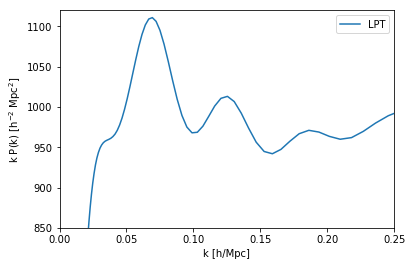

In [6]:
# The (real space) power spectrum:
kv, pth = moments.combine_bias_terms_pk(b1, b2, bs, b3, alpha, sn)
plt.semilogx( kv, kv * pth,label=r'LPT' )

plt.legend()
plt.xscale('linear')

plt.xlim(0,0.25)
plt.ylim(850,1120)

plt.ylabel(r'k P(k) [h$^{-2}$ Mpc$^2$]')
plt.xlabel('k [h/Mpc]')
plt.show()

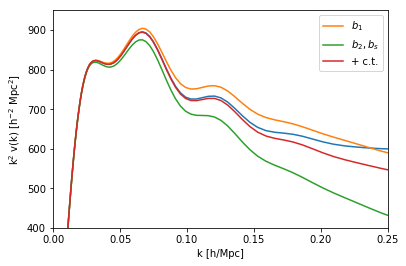

In [7]:
# the 1st pairwise velocity moment
kv, vth = moments.combine_bias_terms_vk(b1, b2, bs, b3, alpha_v, sv)
plt.semilogx( kv, -f*kv**2 * vth )

kv, vth = moments.combine_bias_terms_vk(b1, 0, 0, 0, 0, 0)
plt.semilogx( kv, -f*kv**2 * vth, label=r'$b_1$' )

kv, vth = moments.combine_bias_terms_vk(b1, b2, bs, b3, 0, 0)
plt.semilogx( kv, -f*kv**2 * vth, label=r'$b_2, b_s$' )

kv, vth = moments.combine_bias_terms_vk(b1, b2, bs, b3, alpha_v, 0)
plt.semilogx( kv, -f*kv**2 * vth, label=r'+ c.t.' )


plt.legend(loc='upper right')
plt.ylabel(r'k$^2$ v(k) [h$^{-2}$ Mpc$^2$]')

plt.xscale('linear')
plt.xlim(0,0.25)
plt.ylim(400,950)

plt.xlabel('k [h/Mpc]')
plt.show()


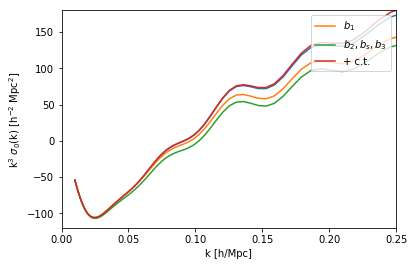

In [8]:
# the 2nd pairwise velocity moment, monopole
# Note that the default basis is polynomial in mu for rsd convenience
# but for velocities only better to look at Legendre (multipole) basis

kv, s0th, s2th = moments.combine_bias_terms_sk(b1, b2, bs, b3, alpha_s0, alpha_s2, s0, basis='Legendre')
plt.semilogx( kv, f**2*kv**3 * s0th )

kv, s0th, s2th = moments.combine_bias_terms_sk(b1, 0, 0, 0, 0, 0, 0, basis='Legendre')
plt.semilogx( kv, f**2*kv**3 * s0th, label=r'$b_1$' )

kv, s0th, s2th = moments.combine_bias_terms_sk(b1, b2, bs, b3, 0, 0, 0, basis='Legendre')
plt.semilogx( kv, f**2*kv**3 * s0th, label=r'$b_2, b_s, b_3$' )

kv, s0th, s2th = moments.combine_bias_terms_sk(b1, b2, bs, b3, alpha_s0, alpha_s2, 0, basis='Legendre')
plt.semilogx( kv, f**2*kv**3 * s0th, label=r'+ c.t.' )


plt.legend(loc='upper right')
plt.ylabel(r'k$^3$ $\sigma_0$(k) [h$^{-2}$ Mpc$^2$]')

plt.xscale('linear')
plt.xlim(0,0.25)
plt.ylim(-120,180)

plt.xlabel('k [h/Mpc]')
plt.show()


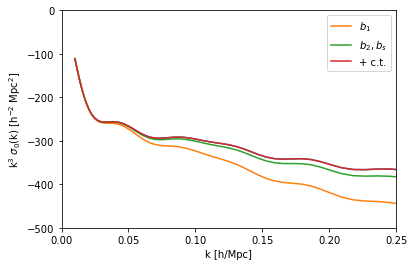

In [ ]:
# the 2nd pairwise velocity moment, quadrupole
kv, s0th, s2th = moments.combine_bias_terms_sk(b1, b2, bs, b3, alpha_s0, alpha_s2, s0, basis='Legendre')
plt.semilogx( kv, f**2*kv**3 * s2th )

kv, s0th, s2th = moments.combine_bias_terms_sk(b1, 0, 0, 0, 0, 0, 0, basis='Legendre')
plt.semilogx( kv, f**2*kv**3 * s2th, label=r'$b_1$' )

kv, s0th, s2th = moments.combine_bias_terms_sk(b1, b2, bs, b3, 0, 0, 0, basis='Legendre')
plt.semilogx( kv, f**2*kv**3 * s2th, label=r'$b_2, b_s$' )

kv, s0th, s2th = moments.combine_bias_terms_sk(b1, b2, bs, b3, alpha_s0, alpha_s2, 0, basis='Legendre')
plt.semilogx( kv, f**2*kv**3 * s2th, label=r'+ c.t.' )


plt.legend(loc='upper right')
plt.ylabel(r'k$^3$ $\sigma_0$(k) [h$^{-2}$ Mpc$^2$]')

plt.xscale('linear')
plt.xlim(0,0.25)
plt.ylim(-500,0)

plt.xlabel('k [h/Mpc]')
plt.show()

In [ ]:
# Now combine into wedges via the moment expansion
plt.figure(figsize=(8,5))

mus = [0.1, 0.3, 0.5, 0.7, 0.9]


for ii, mu in enumerate(mus):
    
    # The c3 parameter is the counterterm ansatz to the third moment
    # Note that c3 enters as c3 / 6 * k^2 mu^4 P(k)
    kw, pw = moments.compute_redshift_space_power_at_mu(pars,f,mu,counterterm_c3=-120)
    plt.plot(kw, kw*pw,'C'+str(ii)+'-',label=r'$\mu = %.1f$'%(mu))
    
    kw, pw = moments.compute_redshift_space_power_at_mu(pars,f,mu,counterterm_c3=0)
    plt.plot(kw, kw*pw,'C'+str(ii)+'--')

plt.plot(kw, -1000*kw, 'k--', label='n = 2')    
    
plt.ylabel(r'$k P(k,\mu)$ [(Mpc/h)$^2$]')


plt.xlim(0,0.25)
plt.ylim(500,2000)

plt.legend(ncol=3,loc='lower right')



plt.show()

In [ ]:
# ... and multipoles
plt.figure(figsize=(8,5))

ks, p0g, p2g, p4g = moments.compute_redshift_space_power_multipoles(pars,f,counterterm_c3=-120)
ks, p0, p2, p4 = moments.compute_redshift_space_power_multipoles(pars,f,counterterm_c3=0)

plt.plot(ks, -1000*ks,'k--',label='n=2')
plt.plot(ks, -1000*ks,'k-',label='+ c.t.')


plt.plot(ks, ks*p0,'C0-',label=r'$\ell = 0$')
plt.plot(ks, ks*p0g,'C0--')

plt.plot(ks, ks*p2,'C1-',label=r'$\ell = 2$')
plt.plot(ks, ks*p2g,'C1--')

plt.plot(ks, ks*p4,'C2-',label=r'$\ell = 4$')
plt.plot(ks, ks*p4g,'C2--')

plt.xlabel('k [h/Mpc]')
plt.ylabel(r'$k P_\ell(k)$ [(Mpc/h)$^2$]')

plt.xlim(0,0.25)
plt.ylim(0,1600)

plt.legend(ncol=3,loc='upper right')

plt.show()

In [ ]:
# Note that we can also enter a more reduced set of parameters using the "reduced" keyword
# These are:
# the bias parameters b1, b2, bs
# the counterterms alpha0, alpha2, alpha4,
# and the stochastic contributions sn, s0
# In this case the "counterterm_c3" parameters is unused because it is subsumed by alpha4

# As an example let's take:
pars = [0.7, 0.5, -0.3, 0, 10, 20, -60, 1800, -1000]

# Now combine into wedges via the moment expansion...
# Compared here to Kaiser x Real Space P(k), which is very different!

plt.figure(figsize=(8,5))

mus = [0.1, 0.3, 0.5, 0.7, 0.9]


for ii, mu in enumerate(mus):
    
    kw, pw = moments.compute_redshift_space_power_at_mu(pars,f,mu,reduced=True)
    plt.plot(kw, kw*pw,'C'+str(ii)+'-',label=r'$\mu = %.1f$'%(mu))
    
    kw, pw = moments.compute_redshift_space_power_at_mu(pars,f,0,reduced=True)
    plt.plot(kw, kw *( (1 + pars[0] + f*mu**2)**2 / (1 + pars[0])**2 * (pw-pars[7]) + pars[7]),'C'+str(ii)+'--')
    
plt.plot(kw, -1000*kw, 'k--',label='Kaiser')
plt.ylabel(r'$k P(k,\mu)$ [(Mpc/h)$^2$]')


plt.xlim(0,0.25)
plt.ylim(500,2100)

plt.legend(ncol=3,loc='lower right')



plt.show()


In [ ]:
# and similarly for multipoles:

plt.figure(figsize=(8,5))

ks, p0, p2, p4 = moments.compute_redshift_space_power_multipoles(pars,f,reduced=True)


plt.plot(ks, ks*p0,'C0-',label=r'$\ell = 0$')

plt.plot(ks, ks*p2,'C1-',label=r'$\ell = 2$')

plt.plot(ks, ks*p4,'C2-',label=r'$\ell = 4$')

plt.xlabel('k [h/Mpc]')
plt.ylabel(r'$k P_\ell(k)$ [(Mpc/h)$^2$]')

plt.xlim(0,0.25)
plt.ylim(0,1600)

plt.legend(ncol=3,loc='upper right')

plt.show()
